In [36]:
#import os
import sys
sys.path.append("../python/")
from helpers import *

import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as tkr

from scipy.stats import ttest_ind # for independent t-test

In [2]:
SENSITIVITY_RESULTS_DIR = '../../results/sensitivity-tests'
SCENARIO_LIST = ["Pr_Im", "PrPo_Im", "Pr_PoIm", "Pr_Po_Im"]

In [3]:
def getPerformanceDataFrame():
    result_file_list = getListOfFiles(SENSITIVITY_RESULTS_DIR)
    df = pd.DataFrame()
    for filename in result_file_list:
        if "scenario_resolution_" in filename:
            performance_dict = json.load(open(filename))
            performance_df = pd.DataFrame(performance_dict["metrics"])
            performance_df['epoch'] = performance_df.index + 1
            performance_df["resolution"] = performance_dict["image_size"]
            performance_df["scenario"] = performance_dict["scenario"]
            performance_df["best_val_accuracy"] = performance_dict["best_val_accuracy"]
            performance_df["trial"] = int(filename.split("_")[-1].split(".")[0])
            df = df.append(performance_df, ignore_index=True)
    return(df)

In [16]:
def plotMeanAccuracyLoss():
    df = getPerformanceDataFrame()
    melted_df = df.melt(id_vars = ["epoch", "resolution", "scenario"], value_vars = ["loss", "accuracy", "val_loss", "val_accuracy"], var_name = "metric", value_name = "value")
    melted_df["type"] = None
    melted_df.loc[melted_df.metric.isin(["loss", "val_loss"]), "type"] = "Loss"
    melted_df.loc[melted_df.metric.isin(["accuracy", "val_accuracy"]), "type"] = "Accuracy"
    
    num_scenarios = len(df.scenario.unique())
    num_resolutions = len(df.resolution.unique())
    num_epochs = df.epoch.max()
    sns.set_style("whitegrid")
    g = sns.FacetGrid(melted_df, col="scenario", row="type", sharey = False)
    g.map_dataframe(sns.lineplot, x = "epoch", y = "value", style = "metric", hue = "resolution", palette= sns.color_palette("Set1", n_colors=2) )
    g.set_axis_labels("Epoch", "")
    g.add_legend() 
    ## Customize legend
    g._legend.texts[0].set_text("Resolution")
    g._legend.texts[num_resolutions + 1].set_text("") #Data
    g._legend.texts[num_resolutions + 2].set_text("Training")
    g._legend.texts[num_resolutions + 3].set_text("Validation")    
    g._legend.texts[num_resolutions + 4].set_text("")    
    g._legend.texts[num_resolutions + 5].set_text("")    
    g._legend.legendHandles[num_resolutions + 4].set_linewidth(0)
    g._legend.legendHandles[num_resolutions + 5].set_linewidth(0)    
    g._legend._legend_box.sep = 5
    axes = g.axes
    for row, axlist in enumerate(axes):
        if row==0:
            for col, axis in enumerate(axes[row]):
                axes[row, col].set_ylim(0, 1)#.75 
                axes[row, col].set_xlim(1, num_epochs)
                axes[row, col].xaxis.set_major_locator(tkr.AutoLocator())
                axes[row, col].set_title("Scenario: " + 
                                         str(axes[row, col].title).split("scenario = ")[1].split(")")[0].split("\'")[0])
                if col != 0:
                    axes[row, col].get_yaxis().set_ticklabels([])
                else:
                    axes[row, col].set_ylabel("Loss")
        elif row==1:
            for col, axis in enumerate(axes[row]):
                axes[row, col].set_ylim(0.5, 1)
                axes[row, col].set_xlim(1, num_epochs)
                axes[row, col].set_title("")
                if col != 0:
                    axes[row, col].get_yaxis().set_ticklabels([])
                else:
                    axes[row, col].set_ylabel("Accuracy")
    g.savefig("../../figures/scenario_resolution_performance.png", dpi=180)
    return(g)

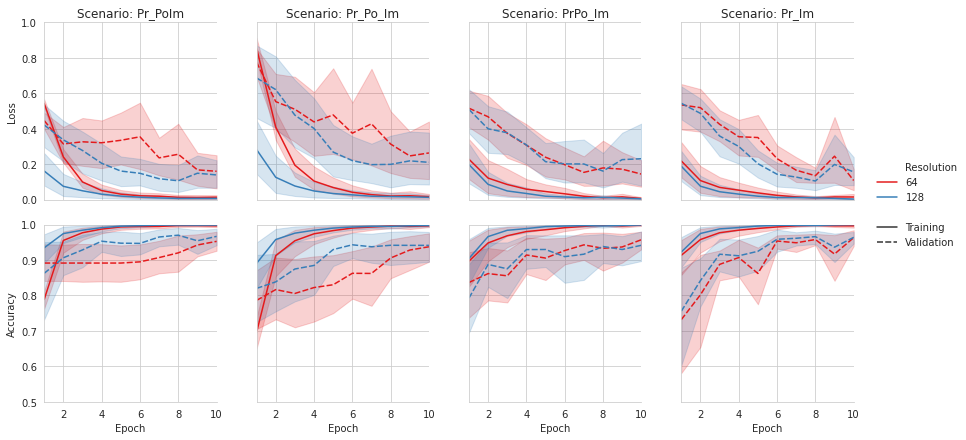

In [17]:
gg = plotMeanAccuracyLoss()

                     mean  stdev
scenario resolution             
PrPo_Im  64          0.96   0.04
         128         0.96   0.05
Pr_Im    64          0.98   0.03
         128         0.97   0.03
Pr_PoIm  64          0.96   0.04
         128         0.97   0.04
Pr_Po_Im 64          0.94   0.07
         128         0.95   0.07
Pr_Im
Ttest_indResult(statistic=0.01976319227745044, pvalue=0.9844497250404811)
PrPo_Im
Ttest_indResult(statistic=0.12736637270221182, pvalue=0.9000692161378825)
Pr_PoIm
Ttest_indResult(statistic=-0.5774249964466084, pvalue=0.5708865782894896)
Pr_Po_Im
Ttest_indResult(statistic=-0.2687318482734897, pvalue=0.7911938250945417)


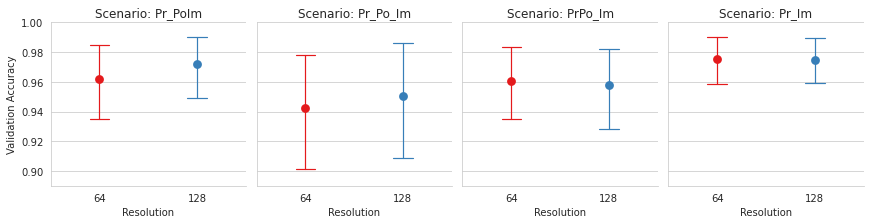

In [87]:
def plotMeanValidationAccuracy():
    df = getPerformanceDataFrame()
    df = df[['scenario', "resolution", "trial", 'best_val_accuracy']].drop_duplicates()
    #df1['resolution'] = df1['resolution'].map(str)
    df = df.melt(id_vars = ['scenario', "resolution", "trial"], value_vars = ["best_val_accuracy"], var_name = "metric", value_name = "value")
    dfacc = df.groupby(["scenario", "resolution"]).mean()
    dfacc = dfacc.drop(["trial"], axis = 1)
    dfacc.columns = ['mean']
    dfacc['stdev'] = df.groupby(["scenario", "resolution"]).std()['value']
    print(np.round(dfacc,2))
    for s in SCENARIO_LIST:
        print(s)
        dfs = df[df.scenario==s]
        print(ttest_ind(dfs.loc[dfs.resolution==64,'value'], dfs.loc[dfs.resolution==128,'value'], equal_var=False))
    g = sns.FacetGrid(df1, col="scenario", sharey = True)
    g.map_dataframe(sns.pointplot, x = "resolution", y = "value", 
                 hue = "resolution", palette= sns.color_palette("Set1", n_colors=2), capsize = .2, errwidth=1.2)
    g.set(ylim =(.89,1.0))
    g.set_axis_labels("Resolution", "Validation Accuracy")
    axes = g.axes
    for row, axlist in enumerate(axes):
        for col, axis in enumerate(axes[row]):
            axes[row,col].set_title("Scenario: " + 
                                 str(axes[row,col].title).split("scenario = ")[1].split(")")[0].split("\'")[0])
    g.savefig("../../figures/scenario_resolution_validation_accuracy.png", dpi=180)
    return
plotMeanValidationAccuracy()
# g2.map_dataframe(sns.boxplot, x = "resolution", y = "value", 
#                  hue = "resolution", palette= sns.color_palette("Set1", n_colors=2), 
#                  showmeans=True, meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"gray"})
